In [1]:
import rnn_models
import rnn_helpers
import imdb_helpers

import matplotlib.pyplot as plt
import numpy as np

import pickle

import nltk
from nltk.corpus import stopwords

In [2]:
from rnn_models import *
from rnn_helpers import *
from imdb_helpers import *

import torch
import torch.nn as nn

In [30]:
import importlib
importlib.reload(rnn_models)
importlib.reload(rnn_helpers)
importlib.reload(imdb_helpers)
from rnn_models import *
from rnn_helpers import *
from imdb_helpers import *

In [3]:
# get training data and create a dictionary of words
data_path = '/Users/markliammurphy/Desktop/ESE599/imdb_sentiment_analysis/aclImdb'
train_reviews, train_targets = read_reviews(data_path)
test_reviews, test_targets = read_reviews(data_path, True)

## RNN with word embeddings

In [97]:
# find the top words in the dictionary and limit reviews
vocab_size = 200
train_reviews_preprocessed, dictionary = preprocess_reviews(train_reviews, 
                                                            vocab_size)
test_reviews_preprocessed = process_reviews(test_reviews, dictionary)

In [98]:
embedding_size = 50
embeds = embed_reviews(embedding_size, dictionary)

In [102]:
n_words = len(dictionary)
n_hidden = embedding_size
model = MinibatchRNN1(embedding_size, n_hidden)

criterion = nn.BCEWithLogitsLoss()
learning_rate = 0.0001
gradient_norm = 0.1
optimizer = torch.optim.Adam(model.parameters(), 
                             lr=learning_rate)

n_epochs = 2
batch_size = 4
n = len(train_reviews)
n_batches = int(np.ceil(n / batch_size))
print_every = 100

all_losses = []
current_loss = 0
epoch_losses = []
        
train_reviews_arr = np.array(train_reviews_preprocessed)
train_targets_arr = np.array(train_targets)

for i in range(1, n_epochs + 1):
    # get indices for minibatches
    batch_ind = np.tile(range(n_batches), batch_size)[0:n]
    np.random.shuffle(batch_ind)

    # train and record losses for each batch
    for batch_i in range(n_batches):
        batch = prepare_embedded_batch(train_reviews_arr[batch_ind == batch_i],
                                       train_targets_arr[batch_ind == batch_i],
                                       dictionary, embeds)
        
        output, loss = train_minibatch(batch, model, criterion, optimizer, 
                                       gradient_norm, vocab_size)
        current_loss += loss
        all_losses.append(loss / batch_size)
        
        if batch_i % print_every == 0:
            print('epoch: %d\tbatch: %d\tloss: %.4f' %
                  (i, batch_i, loss))
        
    epoch_losses.append(current_loss / n)

epoch: 1	batch: 0	loss: 0.6203
epoch: 1	batch: 100	loss: 0.7151
epoch: 1	batch: 200	loss: 0.6471
epoch: 1	batch: 300	loss: 0.6478
epoch: 1	batch: 400	loss: 0.7246
epoch: 1	batch: 500	loss: 0.6560
epoch: 1	batch: 600	loss: 0.7031
epoch: 1	batch: 700	loss: 0.7151
epoch: 1	batch: 800	loss: 0.6691
epoch: 1	batch: 900	loss: 0.6317
epoch: 1	batch: 1000	loss: 0.6102
epoch: 1	batch: 1100	loss: 0.8034
epoch: 1	batch: 1200	loss: 0.6675
epoch: 1	batch: 1300	loss: 0.6235
epoch: 1	batch: 1400	loss: 0.6483
epoch: 1	batch: 1500	loss: 0.7727
epoch: 1	batch: 1600	loss: 0.6637
epoch: 1	batch: 1700	loss: 0.6011
epoch: 1	batch: 1800	loss: 0.7214
epoch: 1	batch: 1900	loss: 0.6968
epoch: 1	batch: 2000	loss: 0.6790
epoch: 1	batch: 2100	loss: 0.7114
epoch: 1	batch: 2200	loss: 0.7063
epoch: 1	batch: 2300	loss: 0.6367
epoch: 1	batch: 2400	loss: 0.7305
epoch: 1	batch: 2500	loss: 0.6198
epoch: 1	batch: 2600	loss: 0.6524
epoch: 1	batch: 2700	loss: 0.5990
epoch: 1	batch: 2800	loss: 0.7185
epoch: 1	batch: 2900	loss:

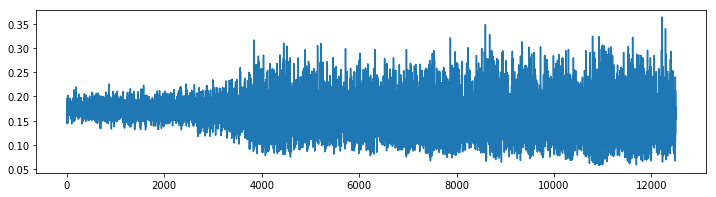

In [109]:
plt.figure(figsize=(12, 3))
plt.plot(all_losses)

In [104]:
batch_size = 500
test_reviews_arr = np.array(test_reviews_preprocessed)
test_targets_arr = np.array(test_targets)
n = len(test_reviews_arr)
n_batches = int(np.ceil(n / batch_size))
err = 0
for i in range(n_batches):
    start_ind = i * n_batches
    end_ind = i * n_batches + n_batches
    batch = prepare_embedded_batch(test_reviews_arr[start_ind:end_ind],
                                   test_targets_arr[start_ind:end_ind],
                                   dictionary, embeds)
    batch_target, batch_reviews, lengths = batch
    output = model(batch_reviews, lengths)
    prediction = nn.Sigmoid()(output)
    prediction_thresholded = (prediction > 0.5).float()
    err += sum(prediction_thresholded != batch_target).item()
err = err / n

In [105]:
print("Test error: %.4f" % err)

Test error: 0.0315


## RNN with word embeddings, no stop words

In [ ]:
# filter out stop words
nltk.download("stopwords")
stop_words = set(stopwords.words('english'))
train_reviews_filtered = [[w for w in review if w not in stop_words] 
                          for review in train_reviews]
test_reviews_filtered = [[w for w in review if w not in stop_words]
                         for review in test_reviews]

In [17]:
# find the top words in the dictionary and limit reviews
vocab_size = 1000
train_reviews_preprocessed, dictionary = preprocess_reviews(train_reviews_filtered, 
                                                            vocab_size)
test_reviews_preprocessed = process_reviews(test_reviews_filtered, dictionary)

In [18]:
embedding_size = 300
embeds = embed_reviews(embedding_size, dictionary)

In [19]:
n_words = len(dictionary)
n_hidden = embedding_size
model = MinibatchRNN1(embedding_size, n_hidden)

criterion = nn.BCEWithLogitsLoss()
learning_rate = 0.00001
gradient_norm = 0.05
optimizer = torch.optim.Adam(model.parameters(), 
                             lr=learning_rate)

n_epochs = 8
batch_size = 8
n = len(train_reviews)
n_batches = int(np.ceil(n / batch_size))
print_every = 100

all_losses = []
current_loss = 0
epoch_losses = []
        
train_reviews_arr = np.array(train_reviews_preprocessed)
train_targets_arr = np.array(train_targets)

for i in range(1, n_epochs + 1):
    # get indices for minibatches
    batch_ind = np.tile(range(n_batches), batch_size)[0:n]
    np.random.shuffle(batch_ind)

    # train and record losses for each batch
    for batch_i in range(n_batches):
        batch = prepare_embedded_batch(train_reviews_arr[batch_ind == batch_i],
                                       train_targets_arr[batch_ind == batch_i],
                                       dictionary, embeds)
        
        output, loss = train_minibatch(batch, model, criterion, optimizer, 
                                       gradient_norm, vocab_size)
        current_loss += loss
        all_losses.append(loss)
        
        if batch_i % print_every == 0:
            print('epoch: %d\tbatch: %d\tloss: %.4f' %
                  (i, batch_i, loss))
        
    epoch_losses.append(current_loss / n)
    current_loss = 0

epoch: 1	batch: 0	loss: 0.7017
epoch: 1	batch: 100	loss: 0.6842
epoch: 1	batch: 200	loss: 0.7222
epoch: 1	batch: 300	loss: 0.6998
epoch: 1	batch: 400	loss: 0.6593
epoch: 1	batch: 500	loss: 0.7031
epoch: 1	batch: 600	loss: 0.6994
epoch: 1	batch: 700	loss: 0.7078
epoch: 1	batch: 800	loss: 0.6582
epoch: 1	batch: 900	loss: 0.7182
epoch: 1	batch: 1000	loss: 0.7158
epoch: 1	batch: 1100	loss: 0.6694
epoch: 1	batch: 1200	loss: 0.6779
epoch: 1	batch: 1300	loss: 0.7214
epoch: 1	batch: 1400	loss: 0.6535
epoch: 1	batch: 1500	loss: 0.7077
epoch: 1	batch: 1600	loss: 0.6287
epoch: 1	batch: 1700	loss: 0.6842
epoch: 1	batch: 1800	loss: 0.7350
epoch: 1	batch: 1900	loss: 0.6933
epoch: 1	batch: 2000	loss: 0.7379
epoch: 1	batch: 2100	loss: 0.6663
epoch: 1	batch: 2200	loss: 0.7631
epoch: 1	batch: 2300	loss: 0.6242
epoch: 1	batch: 2400	loss: 0.6431
epoch: 1	batch: 2500	loss: 0.7244
epoch: 1	batch: 2600	loss: 0.6949
epoch: 1	batch: 2700	loss: 0.5918
epoch: 1	batch: 2800	loss: 0.7007
epoch: 1	batch: 2900	loss:

epoch: 8	batch: 2000	loss: 0.2839
epoch: 8	batch: 2100	loss: 0.6783
epoch: 8	batch: 2200	loss: 0.3453
epoch: 8	batch: 2300	loss: 0.5643
epoch: 8	batch: 2400	loss: 0.3410
epoch: 8	batch: 2500	loss: 0.7850
epoch: 8	batch: 2600	loss: 0.7332
epoch: 8	batch: 2700	loss: 0.3348
epoch: 8	batch: 2800	loss: 0.3243
epoch: 8	batch: 2900	loss: 0.3044
epoch: 8	batch: 3000	loss: 0.1887
epoch: 8	batch: 3100	loss: 0.4912


In [ ]:
plt.figure(figsize=(12, 3))
plt.plot(all_losses)


In [ ]:
[epoch_losses[i] - sum(epoch_losses[0:i]) for i in range(n_epochs)]

In [21]:
batch_size = 500
test_reviews_arr = np.array(test_reviews_preprocessed)
test_targets_arr = np.array(test_targets)
n = len(test_reviews_arr)
n_batches = int(np.ceil(n / batch_size))
err = 0
for i in range(n_batches):
    start_ind = i * n_batches
    end_ind = i * n_batches + n_batches
    batch = prepare_embedded_batch(test_reviews_arr[start_ind:end_ind],
                                   test_targets_arr[start_ind:end_ind],
                                   dictionary, embeds)
    batch_target, batch_reviews, lengths = batch
    output = model(batch_reviews, lengths)
    prediction = nn.Sigmoid()(output)
    prediction_thresholded = (prediction > 0.5).float()
    err += sum(prediction_thresholded != batch_target).item()
err = err / n

In [22]:
print("Test error: %.4f" % err)

Test error: 0.0155


## LSTM with embeddings, no stop words

In [4]:
# filter out stop words
nltk.download("stopwords")
stop_words = set(stopwords.words('english'))
train_reviews_filtered = [[w for w in review if w not in stop_words] 
                          for review in train_reviews]
test_reviews_filtered = [[w for w in review if w not in stop_words]
                         for review in test_reviews]

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/markliammurphy/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [25]:
# find the top words in the dictionary and limit reviews
vocab_size = 4193
train_reviews_preprocessed, dictionary = preprocess_reviews(train_reviews_filtered, 
                                                            vocab_size)
test_reviews_preprocessed = process_reviews(test_reviews_filtered, dictionary)

In [32]:
embedding_size = 100
embeds = embed_reviews(embedding_size, dictionary)

In [40]:
n_words = len(dictionary)
n_hidden = embedding_size
model = MinibatchLSTM(embedding_size, n_hidden)

criterion = nn.BCEWithLogitsLoss()
learning_rate = 0.001
gradient_norm = 0.08
optimizer = torch.optim.Adam(model.parameters(), 
                             lr=learning_rate)

n_epochs = 3
batch_size = 4
n = len(train_reviews)
n_batches = int(np.ceil(n / batch_size))
print_every = 100

all_losses = []
current_loss = 0
epoch_losses = []
        
train_reviews_arr = np.array(train_reviews_preprocessed)
train_targets_arr = np.array(train_targets)

for i in range(1, n_epochs + 1):
    # get indices for minibatches
    batch_ind = np.tile(range(n_batches), batch_size)[0:n]
    np.random.shuffle(batch_ind)

    # train and record losses for each batch
    for batch_i in range(n_batches):
        batch = prepare_embedded_batch(train_reviews_arr[batch_ind == batch_i],
                                       train_targets_arr[batch_ind == batch_i],
                                       dictionary, embeds)
        
        output, loss = train_minibatch(batch, model, criterion, optimizer, 
                                       gradient_norm, vocab_size)
        current_loss += loss
        all_losses.append(loss)
        
        if batch_i % print_every == 0:
            print('epoch: %d\tbatch: %d\tloss: %.4f' %
                  (i, batch_i, loss))
        
    epoch_losses.append(current_loss * batch_size / n)
    current_loss = 0

epoch: 1	batch: 0	loss: 0.6999
epoch: 1	batch: 100	loss: 0.7080
epoch: 1	batch: 200	loss: 0.6674
epoch: 1	batch: 300	loss: 0.7801
epoch: 1	batch: 400	loss: 0.7583
epoch: 1	batch: 500	loss: 0.7037
epoch: 1	batch: 600	loss: 0.5037
epoch: 1	batch: 700	loss: 0.8095
epoch: 1	batch: 800	loss: 0.5105
epoch: 1	batch: 900	loss: 0.6196
epoch: 1	batch: 1000	loss: 0.7972
epoch: 1	batch: 1100	loss: 0.6276
epoch: 1	batch: 1200	loss: 0.6445
epoch: 1	batch: 1300	loss: 0.4049
epoch: 1	batch: 1400	loss: 0.7430
epoch: 1	batch: 1500	loss: 0.5702
epoch: 1	batch: 1600	loss: 0.3418
epoch: 1	batch: 1700	loss: 0.8858
epoch: 1	batch: 1800	loss: 0.1618
epoch: 1	batch: 1900	loss: 0.3359
epoch: 1	batch: 2000	loss: 0.5634
epoch: 1	batch: 2100	loss: 0.1650
epoch: 1	batch: 2200	loss: 0.3878
epoch: 1	batch: 2300	loss: 0.5194
epoch: 1	batch: 2400	loss: 0.4067
epoch: 1	batch: 2500	loss: 0.3034
epoch: 1	batch: 2600	loss: 0.7223
epoch: 1	batch: 2700	loss: 0.1911
epoch: 1	batch: 2800	loss: 0.8784
epoch: 1	batch: 2900	loss:

Text(0, 0.5, 'loss')

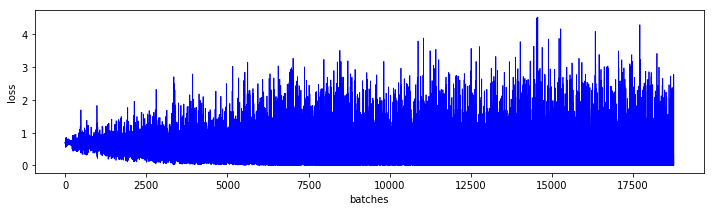

In [52]:
plt.figure(figsize=(12, 3))
plt.plot(all_losses, linewidth=0.8, color='b')
plt.xlabel("batches")
plt.ylabel("loss")

Text(0, 0.5, 'average loss')

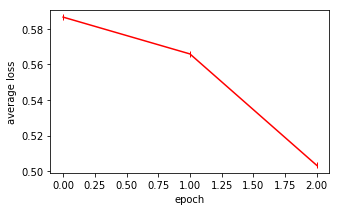

In [60]:
plt.figure(figsize=(5, 3))
plt.plot(epoch_losses, marker='|', color='r')
plt.xlabel("epoch")
plt.ylabel("average loss")

In [43]:
batch_size = 500
test_reviews_arr = np.array(test_reviews_preprocessed)
test_targets_arr = np.array(test_targets)
n = len(test_reviews_arr)
n_batches = int(np.ceil(n / batch_size))
err = 0
for i in range(n_batches):
    start_ind = i * n_batches
    end_ind = i * n_batches + n_batches
    batch = prepare_embedded_batch(test_reviews_arr[start_ind:end_ind],
                                   test_targets_arr[start_ind:end_ind],
                                   dictionary, embeds)
    batch_target, batch_reviews, lengths = batch
    output = model(batch_reviews, lengths)
    prediction = nn.Sigmoid()(output)
    prediction_thresholded = (prediction > 0.5).float()
    err += sum(prediction_thresholded != batch_target).item()
err = err / n

In [44]:
print("Test error: %.4f" % err)

Test error: 0.0147


In [62]:
torch.save(model.state_dict(), './models/lstm')
with open('./models/lstm.pkl', 'wb') as f:
    pickle.dump(all_losses, f)
with open('./models/lstm_epoch_losses.pkl', 'wb') as f:
    pickle.dump(epoch_losses, f)